# Importing Modules

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# General Utilities

### Input:  The images & their titles; others configurations are optional
### Description: Since we'll be previewing alot of images (it's a computer vision course), it's quite handy to have a rendering function

In [36]:
def RenderImages(images: list, titles: list, nrows = 1, ncols = 3, figsize = (36, 48), cmap = 'gray') -> None:
    plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    for i in range(len(images)):
        plt.subplot(nrows, ncols, (i + 1))
        plt.title(titles[i])
        plt.imshow(images[i], cmap = cmap)

# Part I 

## Transform Image

### Input: Image location & Color Weights (optional), by default is set to the weights of the specified rule
### Output: A 2D array representing the greyscale version of the image
### Description: Converting colored data to greyscale according to: $I_{grey}(p) = 0.3 \times I_{red}(p) + 0.59 \times I_{green}(p) + 0.11 \times I_{blue}(p)$

In [31]:
def TransformImage(image: str, colorWeights = [0.3, 0.59, 0.11]) -> np.ndarray:
    return np.array(plt.imread(image)).dot(colorWeights)

#### Importing Image Samples

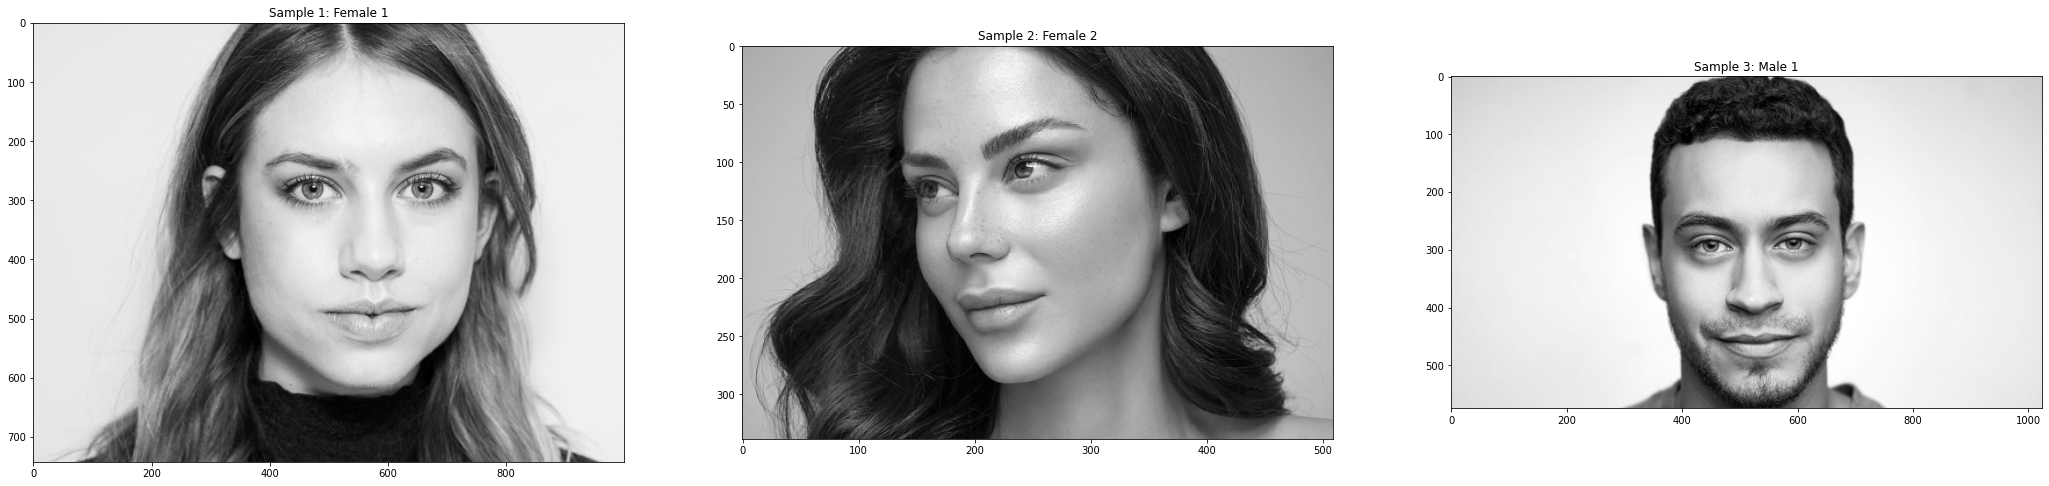

In [38]:
image_female_1 = TransformImage('Samples/f2.png')
image_female_2 = TransformImage('Samples/f6.jpg')
image_male_1   = TransformImage('Samples/f3.jpg')

RenderImages([image_female_1, image_female_2, image_male_1], ['Sample 1: Female 1', 'Sample 2: Female 2', 'Sample 3: Male 1'])

## Calculate Integral Image

### Input:       2D array representing the image
### Output:      2D array representing the integral image
### Description: The implementation is done in two loops (i.e. steps); integrate the rows then integrate the columns

In [29]:
def CalculateIntegral(image: np.ndarray) -> np.ndarray:
    return image.cumsum(axis=0).cumsum(axis=1)

#### Integrals of Sample Images

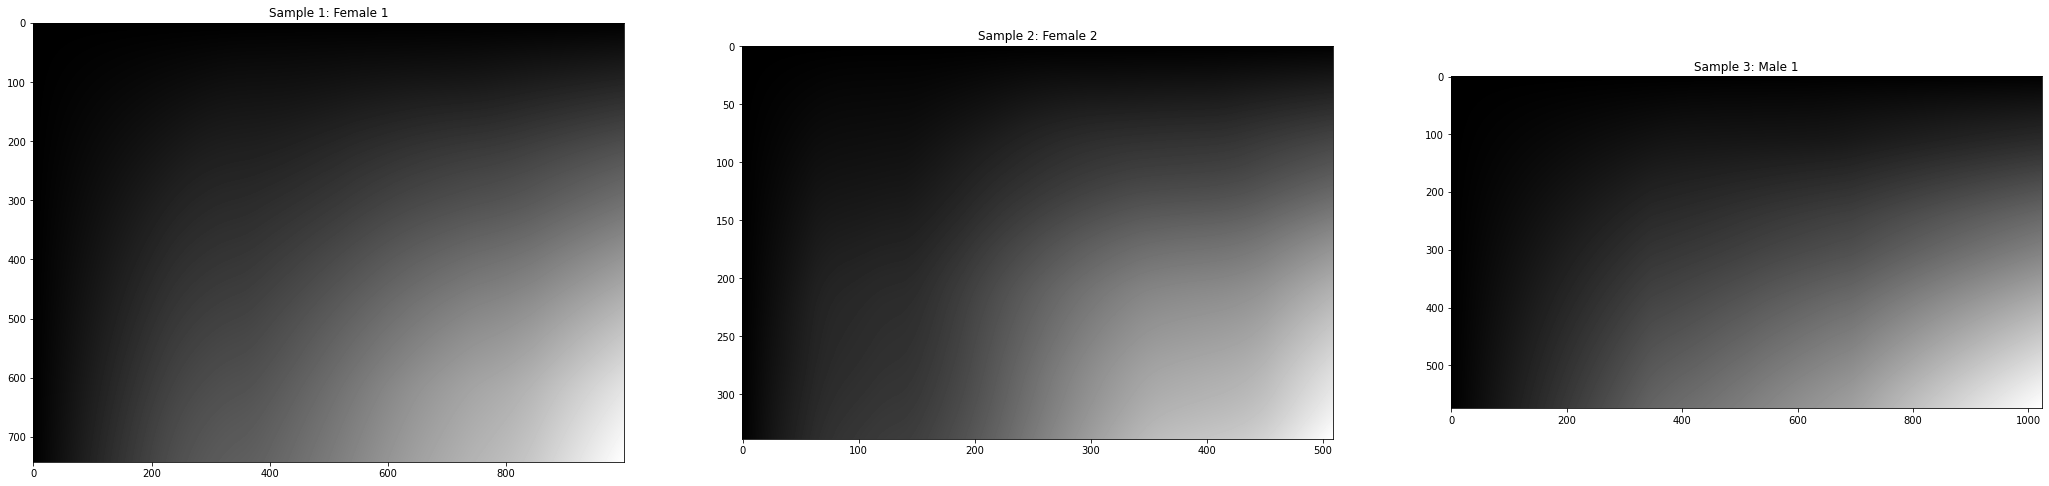

In [39]:
image_integral_female_1 = CalculateIntegral(image_female_1)
image_integral_female_2 = CalculateIntegral(image_female_2)
image_integral_male_1   = CalculateIntegral(image_male_1)

RenderImages([image_integral_female_1, image_integral_female_2, image_integral_male_1], ['Sample 1: Female 1', 'Sample 2: Female 2', 'Sample 3: Male 1'])

## Calculate Local Sum

### Input:  An integral image, and a pair of coordinates $( p_0 = (x_0, y_0), p_1 = (x_1, y_1) )$
### Output: The local sum for the rectangular area defined by the pair of points

NO LOGICAL CHECKS ARE PERFORMED. THE USER HAS TO SET THE FIRST POINT TO BE THE UPPER LEFT & THE SECOND TO BE THE LOWER LEFT

In [47]:
def CalculateLocalSum(integralImage: np.ndarray, point1: tuple[int, int], point2: tuple[int, int]):
    return (integralImage[point1[0], point1[1]] + integralImage[point2[0], point2[1]]) - (integralImage[point2[0], point1[1]] + integralImage[point1[0], point2[1]])

# Part II

## Detect Eyes